<a href="https://colab.research.google.com/github/Dey313/ResEthiq/blob/main/Prototype_1_Test_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install + Imports

In [1]:
!pip -q install openpyxl

import io, os, json, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import files
from sklearn.ensemble import IsolationForest


In [ ]:
FILE UPLOAD

In [9]:
uploaded = files.upload()
filename = next(iter(uploaded.keys()))
print("Uploaded:", filename)

def load_df(filename: str) -> pd.DataFrame:
    if filename.lower().endswith(".csv"):
        return pd.read_csv(io.BytesIO(uploaded[filename]))
    elif filename.lower().endswith(".xlsx"):
        return pd.read_excel(io.BytesIO(uploaded[filename]))
    else:
        raise ValueError("Only CSV or XLSX supported.")

df = load_df(filename)
print(df.shape)
df.head()


Saving AI_Impact_Analysis_on_Silchar_Restaurants.csv to AI_Impact_Analysis_on_Silchar_Restaurants.csv
Uploaded: AI_Impact_Analysis_on_Silchar_Restaurants.csv
(9, 4)


,Restaurant Metric,Before AI Implementation,After AI Implementation,Projected Improvement (%)
0,Customer Satisfaction Score,6.5,8.8,35.38
1,Order Processing Time (mins),35.0,20.0,42.86
2,Revenue Growth (%),5.0,15.0,200.00
3,Food Wastage Reduction (%),10.0,30.0,200.00
4,Operational Efficiency (%),55.0,80.0,45.45


In [11]:
CONFIG = {
    # Overall sanity
    "max_overall_missingness": 0.20,   # 20% average missingness triggers flag

    # Duplicate detection
    "exact_dup_rate_high": 0.02,       # 2% exact duplicates is suspicious

    # Heaping/rounding
    "heaping_last_digit_high": 0.35,   # 35% values ending in 0/5 suggests rounding

    # Likert low variance (if Likert-like columns are detected)
    "likert_var_threshold": 0.25,      # variance below this is "too uniform"
    "likert_low_var_share_high": 0.25, # if 25% of Likert columns are too low variance

    # Unsupervised anomaly detection
    "iforest_contamination": 0.02,     # expected anomaly fraction
    "anomaly_rate_high": 0.05,         # if >5% anomalies => flag

    # Score weighting (risk contributions)
    "weights": {
        "missingness": 0.20,
        "duplicates":  0.25,
        "heaping":     0.15,
        "likert_var":  0.15,
        "anomaly":     0.25
    }
}


In [12]:
def clamp01(x: float) -> float:
    return float(max(0.0, min(1.0, x)))

def add_row_id(df: pd.DataFrame, col="__row_id__") -> pd.DataFrame:
    df = df.copy()
    if col not in df.columns:
        df[col] = [f"r_{i:06d}" for i in range(len(df))]
    return df

def guess_likert_cols(df: pd.DataFrame, exclude=None) -> list:
    exclude = set(exclude or [])
    likerts = []
    for c in df.columns:
        if c in exclude:
            continue
        s = df[c].dropna()
        if len(s) < 30:
            continue
        if pd.api.types.is_numeric_dtype(s):
            # Likert heuristic: small integer-ish support like 1..5 or 1..7
            uniq = sorted(set(np.asarray(s).astype(int).tolist()))
            if len(uniq) in (4,5,6,7) and (max(uniq) - min(uniq) <= 6):
                likerts.append(c)
    return likerts

def last_digit_share(series: pd.Series, digits={0,5}) -> float:
    s = series.dropna()
    if len(s) == 0:
        return 0.0
    vals = np.abs(np.round(s.values).astype(int))
    last = vals % 10
    return float(np.mean(np.isin(last, list(digits))))


In [13]:
def check_missingness(df: pd.DataFrame, cfg: dict):
    overall_missingness = float(df.isna().mean().mean())
    risk = clamp01(overall_missingness / cfg["max_overall_missingness"])
    flag = None
    if overall_missingness >= cfg["max_overall_missingness"]:
        flag = {
            "name": "High missingness",
            "severity": "medium",
            "value": overall_missingness,
            "detail": f"Overall missingness is {overall_missingness:.1%} (threshold {cfg['max_overall_missingness']:.0%})."
        }
    return risk, {"overall_missingness": overall_missingness}, flag

def check_exact_duplicates(df: pd.DataFrame, cfg: dict, exclude_cols=None):
    exclude_cols = set(exclude_cols or [])
    cols = [c for c in df.columns if c not in exclude_cols]
    X = df[cols].copy().fillna("__MISSING__")
    dup_mask = X.duplicated(keep=False)
    exact_rate = float(dup_mask.mean())
    risk = clamp01(exact_rate / cfg["exact_dup_rate_high"])
    flag = None
    if exact_rate >= cfg["exact_dup_rate_high"]:
        flag = {
            "name": "Exact duplicates",
            "severity": "high",
            "value": exact_rate,
            "detail": f"{exact_rate:.1%} of rows are exact duplicates (threshold {cfg['exact_dup_rate_high']:.1%}).",
            "example_row_ids": df.loc[dup_mask, "__row_id__"].tolist()[:50]
        }
    return risk, {"exact_dup_rate": exact_rate}, flag

def check_heaping(df: pd.DataFrame, cfg: dict, exclude_cols=None):
    exclude_cols = set(exclude_cols or [])
    num_cols = [c for c in df.select_dtypes(include="number").columns if c not in exclude_cols]
    best = {"col": None, "share": 0.0}
    for c in num_cols:
        share = last_digit_share(df[c], digits={0,5})
        if share > best["share"]:
            best = {"col": c, "share": share}

    risk = clamp01(best["share"] / cfg["heaping_last_digit_high"]) if best["col"] else 0.0
    flag = None
    if best["col"] and best["share"] >= cfg["heaping_last_digit_high"]:
        flag = {
            "name": "Rounding/heaping",
            "severity": "medium",
            "value": best["share"],
            "detail": f"Column '{best['col']}' has {best['share']:.1%} last-digit 0/5 (threshold {cfg['heaping_last_digit_high']:.0%}).",
            "column": best["col"]
        }
    return risk, {"heaping_col": best["col"], "heaping_share": best["share"]}, flag

def check_likert_variance(df: pd.DataFrame, cfg: dict, exclude_cols=None):
    exclude_cols = set(exclude_cols or [])
    likert_cols = guess_likert_cols(df, exclude=exclude_cols)
    if not likert_cols:
        return 0.0, {"likert_cols": [], "low_var_share": 0.0}, None

    low_var = []
    for c in likert_cols:
        v = float(df[c].var(ddof=1))
        if v < cfg["likert_var_threshold"]:
            low_var.append(c)

    low_var_share = len(low_var) / max(1, len(likert_cols))
    risk = clamp01(low_var_share / cfg["likert_low_var_share_high"])
    flag = None
    if low_var_share >= cfg["likert_low_var_share_high"]:
        flag = {
            "name": "Low variance Likert items",
            "severity": "medium",
            "value": low_var_share,
            "detail": f"{low_var_share:.1%} of Likert-like columns have variance < {cfg['likert_var_threshold']}.",
            "low_var_items": low_var[:50]
        }
    return risk, {"likert_cols": likert_cols, "low_var_share": low_var_share, "low_var_items": low_var}, flag

def check_anomalies(df: pd.DataFrame, cfg: dict, exclude_cols=None):
    exclude_cols = set(exclude_cols or [])
    X = df.drop(columns=[c for c in exclude_cols if c in df.columns], errors="ignore")
    Xn = X.select_dtypes(include="number").copy()

    # Need enough numeric signal
    if Xn.shape[1] < 5 or len(df) < 200:
        return 0.0, {"skipped": True, "reason": "Insufficient numeric features/rows"}, None

    Xn = Xn.fillna(Xn.median(numeric_only=True))
    iso = IsolationForest(contamination=cfg["iforest_contamination"], random_state=42)
    iso.fit(Xn)
    scores = -iso.score_samples(Xn)  # higher = more anomalous

    thresh = np.quantile(scores, 1.0 - cfg["iforest_contamination"])
    mask = scores >= thresh
    anomaly_rate = float(mask.mean())

    risk = clamp01(anomaly_rate / cfg["anomaly_rate_high"])
    flag = None
    if anomaly_rate >= cfg["anomaly_rate_high"]:
        flag = {
            "name": "High anomaly concentration",
            "severity": "high",
            "value": anomaly_rate,
            "detail": f"{anomaly_rate:.1%} of rows are high-anomaly (threshold {cfg['anomaly_rate_high']:.1%}).",
            "example_row_ids": df.loc[mask, "__row_id__"].tolist()[:50]
        }

    return risk, {"anomaly_rate": anomaly_rate, "anomaly_scores": scores.tolist()}, flag


In [15]:
df2 = add_row_id(df)

EXCLUDE = {"__row_id__", "id", "respondent_id", "response_id", "name", "phone", "email"}

risks = {}
metrics = {}
flags = []

r, m, f = check_missingness(df2, CONFIG)
risks["missingness"] = r; metrics.update(m);
if f: flags.append(f)

r, m, f = check_exact_duplicates(df2, CONFIG, exclude_cols=EXCLUDE)
risks["duplicates"] = r; metrics.update(m);
if f: flags.append(f)

r, m, f = check_heaping(df2, CONFIG, exclude_cols=EXCLUDE)
risks["heaping"] = r; metrics.update(m);
if f: flags.append(f)

r, m, f = check_likert_variance(df2, CONFIG, exclude_cols=EXCLUDE)
risks["likert_var"] = r; metrics.update(m);
if f: flags.append(f)

r, m, f = check_anomalies(df2, CONFIG, exclude_cols=EXCLUDE)
risks["anomaly"] = r;
# don't dump huge scores into metrics unless you need it
metrics["anomaly_rate"] = m.get("anomaly_rate", None)
metrics["anomaly_skipped"] = m.get("skipped", False)
if f: flags.append(f)

# Weighted risk aggregation
w = CONFIG["weights"]
total_w = sum(w.values())
weighted_risk = sum(w[k] * risks.get(k, 0.0) for k in w) / max(1e-9, total_w)

# Integrity score: higher is better
integrity_score = int(round(100 * (1.0 - clamp01(weighted_risk))))

if integrity_score >= 80:
    risk_band = "low"
elif integrity_score >= 55:
    risk_band = "medium"
else:
    risk_band = "high"

report = {
    "integrity_score": integrity_score,
    "risk_band": risk_band,
    "module_risks": {k: round(v, 3) for k, v in risks.items()},
    "global_metrics": {
        "n_rows": int(len(df2)),
        "n_cols": int(df2.shape[1]),
        "overall_missingness": metrics.get("overall_missingness")
    },
    "flags": flags,
    "config": CONFIG
}

report


{'integrity_score': 85,
 'risk_band': 'low',
 'module_risks': {'missingness': 0.0,
  'duplicates': 0.0,
  'heaping': 1.0,
  'likert_var': 0.0,
  'anomaly': 0.0},
 'global_metrics': {'n_rows': 9, 'n_cols': 5, 'overall_missingness': 0.0},
 'flags': [{'name': 'Rounding/heaping',
   'severity': 'medium',
   'value': 0.7777777777777778,
   'detail': "Column 'Projected Improvement (%)' has 77.8% last-digit 0/5 (threshold 35%).",
   'column': 'Projected Improvement (%)'}],
 'config': {'max_overall_missingness': 0.2,
  'exact_dup_rate_high': 0.02,
  'heaping_last_digit_high': 0.35,
  'likert_var_threshold': 0.25,
  'likert_low_var_share_high': 0.25,
  'iforest_contamination': 0.02,
  'anomaly_rate_high': 0.05,
  'weights': {'missingness': 0.2,
   'duplicates': 0.25,
   'heaping': 0.15,
   'likert_var': 0.15,
   'anomaly': 0.25}}}

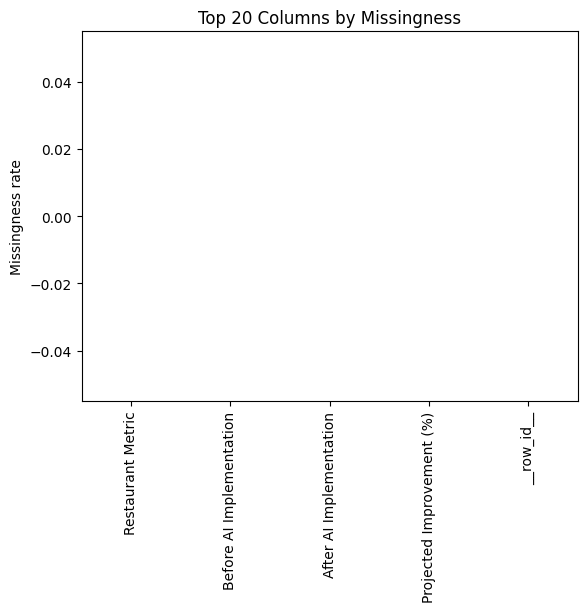

Exact duplicate rate: 0.0


In [16]:
# 1) Missingness bar chart (top 20 missing columns)
miss = df2.isna().mean().sort_values(ascending=False).head(20)
plt.figure()
miss.plot(kind="bar")
plt.title("Top 20 Columns by Missingness")
plt.ylabel("Missingness rate")
plt.show()

# 2) Duplicate summary
print("Exact duplicate rate:", metrics.get("exact_dup_rate"))

# 3) If anomaly ran: plot anomaly score histogram (optional)


In [17]:
out_path = "integrity_report.json"
with open(out_path, "w", encoding="utf-8") as f:
    json.dump(report, f, indent=2)

files.download(out_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**TEST 2**

In [1]:
!pip -q install reportlab openpyxl datasketch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 kB 7.4 MB/s eta 0:00:00


In [2]:
!pip -q install reportlab openpyxl datasketch scikit-learn

import io, os, json, math, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import files

from sklearn.ensemble import IsolationForest
from datasketch import MinHash, MinHashLSH

from reportlab.lib.pagesizes import A4
from reportlab.lib.units import cm
from reportlab.lib import colors
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.platypus import (
    SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle, Image, PageBreak
)


In [3]:
uploaded = files.upload()
filename = next(iter(uploaded.keys()))
print("Uploaded:", filename)

def load_df(filename: str) -> pd.DataFrame:
    if filename.lower().endswith(".csv"):
        return pd.read_csv(io.BytesIO(uploaded[filename]))
    elif filename.lower().endswith(".xlsx"):
        return pd.read_excel(io.BytesIO(uploaded[filename]))
    else:
        raise ValueError("Only CSV or XLSX supported.")

df = load_df(filename)
print("Shape:", df.shape)
df.head()


Saving Book1.xlsx to Book1.xlsx
Uploaded: Book1.xlsx
Shape: (390, 32)


,S.No,Class,Type of School,Age,Sex,Handling of heavy school bag a serious problem,Do you like your school bag?,School bag free educdation,Reasons for heavy bag,Trying to keep school bag lighter,...,Trouble in ankles/feet,Have you at any time during the last 12 months been prevented from doing your normal work because of the trouble?,Have you had trouble at any time during the last 7 days?,Have you ever hurt your body part in an accident?,What is the total length of time that you have had trouble during the last 12 months?,Have you been seen by a doctor because of trouble during the last 12 months?,Visual Analogue Scale,BMI(kg/m2),Bag weight(kg),Relative weight of backpack(%)
0,1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,9,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,0.0,15.0,4.2,17.0
1,2,0.0,0.0,0.0,1.0,1.0,0.0,1.0,9,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,22.5,4.0,14.0
2,3,0.0,0.0,0.0,0.0,1.0,0.0,1.0,4,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,0.0,16.0,3.5,13.0
3,4,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0,0.0,...,1.0,1.0,1.0,1.0,4.0,1.0,0.0,27.0,3.5,8.0
4,5,0.0,0.0,0.0,1.0,0.0,0.0,1.0,"0,3,4",0.0,...,1.0,1.0,1.0,1.0,0.0,1.0,2.0,15.0,4.0,14.0


In [4]:
CONFIG = {
    # Sanity / missingness
    "max_overall_missingness": 0.20,      # 20% avg missingness triggers risk ~1

    # Exact duplicates
    "exact_dup_rate_high": 0.02,          # 2% exact duplicates => high

    # Near-duplicates via MinHash/LSH
    "lsh_threshold": 0.90,                # Jaccard similarity threshold
    "min_cluster_size": 5,
    "near_dup_rate_high": 0.05,           # 5% clustered => high

    # Survey fraud signals
    "straight_line_items_min": 8,
    "straight_line_rate_high": 0.08,      # 8% straight-lining => high
    "long_string_norm_high": 0.60,        # p95 long-run covers >=60% of items

    # Distribution
    "heaping_last_digit_high": 0.35,      # 35% last digit {0,5}
    "likert_var_threshold": 0.25,         # low variance threshold for Likert
    "likert_low_var_share_high": 0.25,    # 25% items low var => high

    # Dependence
    "corr_abs_high": 0.90,
    "corr_share_high": 0.08,              # 8% pairs above corr_abs_high => suspicious

    # Anomaly detection
    "iforest_contamination": 0.02,
    "anomaly_rate_high": 0.05,            # 5% anomalies => high

    # Weights (risk contributions) - must sum to ~1 (we normalize anyway)
    "weights": {
        "missingness": 0.12,
        "duplicates":  0.16,
        "near_dups":   0.18,
        "survey_fraud":0.18,
        "heaping":     0.10,
        "likert_var":  0.08,
        "dependence":  0.10,
        "anomaly":     0.08
    }
}

# Columns to exclude from checks (adjust per dataset)
EXCLUDE = {"__row_id__", "id", "respondent_id", "response_id", "name", "phone", "email"}


In [5]:
def clamp01(x: float) -> float:
    return float(max(0.0, min(1.0, x)))

def add_row_id(df: pd.DataFrame, col="__row_id__") -> pd.DataFrame:
    df = df.copy()
    if col not in df.columns:
        df[col] = [f"r_{i:06d}" for i in range(len(df))]
    return df

def guess_likert_cols(df: pd.DataFrame, exclude=None) -> list:
    exclude = set(exclude or [])
    likerts = []
    for c in df.columns:
        if c in exclude:
            continue
        s = df[c].dropna()
        if len(s) < 30:
            continue
        if pd.api.types.is_numeric_dtype(s):
            # Likert heuristic: small integer-ish support 1..5 or 1..7
            vals = np.asarray(s)
            if np.any(np.isnan(vals)):
                vals = vals[~np.isnan(vals)]
            uniq = sorted(set(np.round(vals).astype(int).tolist()))
            if len(uniq) in (4,5,6,7) and (max(uniq) - min(uniq) <= 6):
                likerts.append(c)
    return likerts

def last_digit_share(series: pd.Series, digits={0,5}) -> float:
    s = series.dropna()
    if len(s) == 0:
        return 0.0
    vals = np.abs(np.round(s.values).astype(int))
    last = vals % 10
    return float(np.mean(np.isin(last, list(digits))))

def safe_str(x, max_len=60):
    s = str(x)
    return s if len(s) <= max_len else s[:max_len-3] + "..."


In [6]:
def check_missingness(df: pd.DataFrame, cfg: dict):
    overall_missingness = float(df.isna().mean().mean())
    risk = clamp01(overall_missingness / cfg["max_overall_missingness"])

    flag = None
    if overall_missingness >= cfg["max_overall_missingness"]:
        flag = {
            "flag": "High missingness",
            "severity": "Medium",
            "module": "missingness",
            "value": overall_missingness,
            "evidence": f"Overall missingness = {overall_missingness:.1%} (threshold {cfg['max_overall_missingness']:.0%}).",
            "action": "Verify collection and export pipeline; check systematic missing blocks."
        }
    return risk, {"overall_missingness": overall_missingness}, flag


In [7]:
def check_exact_duplicates(df: pd.DataFrame, cfg: dict, exclude_cols=None):
    exclude_cols = set(exclude_cols or [])
    cols = [c for c in df.columns if c not in exclude_cols]
    X = df[cols].copy().fillna("__MISSING__")
    dup_mask = X.duplicated(keep=False)
    exact_rate = float(dup_mask.mean())

    risk = clamp01(exact_rate / cfg["exact_dup_rate_high"])
    flag = None
    if exact_rate >= cfg["exact_dup_rate_high"]:
        flag = {
            "flag": "Exact duplicate rows",
            "severity": "High",
            "module": "duplicates",
            "value": exact_rate,
            "evidence": f"{exact_rate:.1%} of rows are exact duplicates (threshold {cfg['exact_dup_rate_high']:.1%}).",
            "action": "Check for copy/paste, merge errors, duplicate submissions; audit respondent IDs."
        }
    return risk, {"exact_dup_rate": exact_rate}, flag


In [8]:
def row_signature_tokens(row, cols):
    toks = []
    for c in cols:
        v = row[c]
        if pd.isna(v):
            v = "__MISSING__"
        toks.append(f"{c}={str(v)}")
    return toks

def check_near_duplicates_minhash(df: pd.DataFrame, cfg: dict, exclude_cols=None):
    exclude_cols = set(exclude_cols or [])
    cols = [c for c in df.columns if c not in exclude_cols]

    if len(cols) < 8 or len(df) < 50:
        return 0.0, {"near_dup_rate": None, "n_clusters": 0, "skipped": True}, None

    # sample for speed in Colab
    if len(df) > 2500:
        df_s = df.sample(2500, random_state=42).copy()
        sampled = True
    else:
        df_s = df.copy()
        sampled = False

    threshold = cfg["lsh_threshold"]
    num_perm = 64
    lsh = MinHashLSH(threshold=threshold, num_perm=num_perm)

    keys = []
    key_to_rowid = {}
    key_to_mh = {}

    # build LSH index
    for i, (_, row) in enumerate(df_s.iterrows()):
        mh = MinHash(num_perm=num_perm)
        for t in row_signature_tokens(row, cols):
            mh.update(t.encode("utf8"))
        k = f"k{i}"
        lsh.insert(k, mh)
        keys.append(k)
        key_to_rowid[k] = row["__row_id__"]
        key_to_mh[k] = mh

    # cluster by querying neighbors
    visited = set()
    clusters = []
    for k in keys:
        if k in visited:
            continue
        nbrs = lsh.query(key_to_mh[k])
        if len(nbrs) >= cfg["min_cluster_size"]:
            cluster_rids = [key_to_rowid[x] for x in nbrs]
            clusters.append(cluster_rids)
            for x in nbrs:
                visited.add(x)

    near_rate = sum(len(c) for c in clusters) / max(1, len(df_s))
    risk = clamp01(near_rate / cfg["near_dup_rate_high"])

    flag = None
    if near_rate >= cfg["near_dup_rate_high"] and clusters:
        clusters_sorted = sorted(clusters, key=len, reverse=True)
        flag = {
            "flag": "Near-duplicate templates (MinHash/LSH)",
            "severity": "High",
            "module": "near_dups",
            "value": near_rate,
            "evidence": (
                f"{near_rate:.1%} of {'sampled ' if sampled else ''}rows fall into near-duplicate clusters "
                f"(Jaccard ≥ {threshold}). Top cluster sizes: {[len(c) for c in clusters_sorted[:5]]}."
            ),
            "action": "Inspect repeated response templates; verify provenance (device logs, timestamps, sampling)."
        }

    return risk, {"near_dup_rate": near_rate, "n_clusters": len(clusters), "sampled": sampled}, flag


In [9]:
def straight_lining_mask(df, likert_cols, min_items=8):
    if len(likert_cols) < min_items:
        return np.zeros(len(df), dtype=bool)
    B = df[likert_cols]
    same = B.nunique(axis=1) == 1
    answered = B.notna().sum(axis=1) >= min_items
    return (same & answered).values

def long_string_index(df, likert_cols):
    if len(likert_cols) == 0:
        return np.zeros(len(df))
    B = df[likert_cols].to_numpy(dtype=float)
    out = np.zeros(B.shape[0])
    for i in range(B.shape[0]):
        row = B[i, :]
        best = 1
        run = 1
        for j in range(1, len(row)):
            if np.isnan(row[j]) or np.isnan(row[j-1]):
                run = 1
            elif row[j] == row[j-1]:
                run += 1
                best = max(best, run)
            else:
                run = 1
        out[i] = best
    return out

def check_survey_fraud(df: pd.DataFrame, cfg: dict, exclude_cols=None):
    exclude_cols = set(exclude_cols or [])
    likert_cols = guess_likert_cols(df, exclude=exclude_cols)

    if len(likert_cols) < cfg["straight_line_items_min"]:
        return 0.0, {"likert_cols": likert_cols, "skipped": True}, None

    straight = straight_lining_mask(df, likert_cols, min_items=cfg["straight_line_items_min"])
    straight_rate = float(np.mean(straight))

    lsi = long_string_index(df, likert_cols)
    lsi_p95 = float(np.percentile(lsi, 95))
    lsi_norm = lsi_p95 / max(1, len(likert_cols))

    straight_high = cfg["straight_line_rate_high"]
    lsi_high = cfg["long_string_norm_high"]

    risk = clamp01(0.8*(straight_rate/straight_high) + 0.6*(lsi_norm/lsi_high))

    flag = None
    if straight_rate >= straight_high or lsi_norm >= lsi_high:
        flag = {
            "flag": "Survey fraud patterns (straight-lining / templating)",
            "severity": "High" if straight_rate >= straight_high else "Medium",
            "module": "survey_fraud",
            "value": {"straight_rate": straight_rate, "lsi_p95": lsi_p95},
            "evidence": (
                f"Straight-lining = {straight_rate:.1%} (thr {straight_high:.1%}); "
                f"Long-string p95 = {lsi_p95:.0f} items (norm {lsi_norm:.2f}, thr {lsi_high:.2f})."
            ),
            "action": "Review respondents with templated patterns; check administration protocol; consider excluding speeders/straight-liners."
        }

    return risk, {"likert_cols_count": len(likert_cols), "straight_rate": straight_rate, "lsi_p95": lsi_p95, "lsi_norm": lsi_norm}, flag


In [10]:
def check_heaping(df: pd.DataFrame, cfg: dict, exclude_cols=None):
    exclude_cols = set(exclude_cols or [])
    num_cols = [c for c in df.select_dtypes(include="number").columns if c not in exclude_cols]
    best_col, best_share = None, 0.0

    for c in num_cols:
        share = last_digit_share(df[c], digits={0,5})
        if share > best_share:
            best_share, best_col = share, c

    risk = clamp01(best_share / cfg["heaping_last_digit_high"]) if best_col else 0.0
    flag = None
    if best_col and best_share >= cfg["heaping_last_digit_high"]:
        flag = {
            "flag": "Rounding / heaping detected",
            "severity": "Medium",
            "module": "heaping",
            "value": best_share,
            "evidence": f"Column '{best_col}' has {best_share:.1%} last-digit 0/5 (thr {cfg['heaping_last_digit_high']:.0%}).",
            "action": "Check if rounding occurred during entry/cleaning; validate measurement precision."
        }
    return risk, {"heaping_col": best_col, "heaping_share": best_share}, flag


In [11]:
def check_likert_variance(df: pd.DataFrame, cfg: dict, exclude_cols=None):
    exclude_cols = set(exclude_cols or [])
    likert_cols = guess_likert_cols(df, exclude=exclude_cols)
    if not likert_cols:
        return 0.0, {"likert_cols": [], "low_var_share": 0.0, "skipped": True}, None

    low_var_items = []
    for c in likert_cols:
        v = float(df[c].var(ddof=1))
        if v < cfg["likert_var_threshold"]:
            low_var_items.append(c)

    low_var_share = len(low_var_items) / max(1, len(likert_cols))
    risk = clamp01(low_var_share / cfg["likert_low_var_share_high"])

    flag = None
    if low_var_share >= cfg["likert_low_var_share_high"]:
        flag = {
            "flag": "Unusually low variance (Likert items)",
            "severity": "Medium",
            "module": "likert_var",
            "value": low_var_share,
            "evidence": f"{low_var_share:.1%} of Likert-like columns have variance < {cfg['likert_var_threshold']}.",
            "action": "Check straight-lining, data cleaning artifacts, or overly uniform synthetic generation."
        }
    return risk, {"likert_cols_count": len(likert_cols), "low_var_share": low_var_share, "low_var_items": low_var_items[:50]}, flag


In [12]:
def check_dependence(df: pd.DataFrame, cfg: dict, exclude_cols=None):
    exclude_cols = set(exclude_cols or [])
    Xn = df.select_dtypes(include="number").drop(columns=[c for c in exclude_cols if c in df.columns], errors="ignore")
    if Xn.shape[1] < 6 or len(df) < 150:
        return 0.0, {"corr_share_high": None, "skipped": True}, None

    Xn = Xn.fillna(Xn.median(numeric_only=True))
    corr = Xn.corr(method="spearman").abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

    corr_thr = cfg["corr_abs_high"]
    share_thr = cfg["corr_share_high"]
    share_high = float((upper >= corr_thr).sum().sum() / max(1, upper.count().sum()))

    risk = clamp01(share_high / share_thr)

    flag = None
    if share_high >= share_thr:
        flag = {
            "flag": "Dependence structure unusually strong",
            "severity": "Medium",
            "module": "dependence",
            "value": share_high,
            "evidence": f"{share_high:.1%} of numeric pairs have |Spearman ρ| ≥ {corr_thr} (thr {share_thr:.1%}).",
            "action": "Review construct overlap and collection process; treat as stronger signal if paired with duplication/fraud flags."
        }
    return risk, {"corr_share_high": share_high, "corr_threshold": corr_thr}, flag


In [13]:
def check_anomalies(df: pd.DataFrame, cfg: dict, exclude_cols=None):
    exclude_cols = set(exclude_cols or [])
    X = df.drop(columns=[c for c in exclude_cols if c in df.columns], errors="ignore")
    Xn = X.select_dtypes(include="number").copy()

    if Xn.shape[1] < 5 or len(df) < 200:
        return 0.0, {"anomaly_rate": None, "skipped": True}, None

    Xn = Xn.fillna(Xn.median(numeric_only=True))
    iso = IsolationForest(contamination=cfg["iforest_contamination"], random_state=42)
    iso.fit(Xn)
    scores = -iso.score_samples(Xn)

    thresh = np.quantile(scores, 1.0 - cfg["iforest_contamination"])
    mask = scores >= thresh
    anomaly_rate = float(mask.mean())

    risk = clamp01(anomaly_rate / cfg["anomaly_rate_high"])

    flag = None
    if anomaly_rate >= cfg["anomaly_rate_high"]:
        flag = {
            "flag": "High anomaly concentration",
            "severity": "High",
            "module": "anomaly",
            "value": anomaly_rate,
            "evidence": f"{anomaly_rate:.1%} of rows are high-anomaly (thr {cfg['anomaly_rate_high']:.1%}).",
            "action": "Inspect top anomalies for impossible combinations; cross-check provenance and collection protocol."
        }

    return risk, {"anomaly_rate": anomaly_rate, "iforest_contamination": cfg["iforest_contamination"]}, flag


In [14]:
df2 = add_row_id(df)

risks = {}
metrics = {}
flags = []

# Run modules
r, m, f = check_missingness(df2, CONFIG); risks["missingness"]=r; metrics.update(m);
if f: flags.append(f)

r, m, f = check_exact_duplicates(df2, CONFIG, exclude_cols=EXCLUDE); risks["duplicates"]=r; metrics.update(m)
if f: flags.append(f)

r, m, f = check_near_duplicates_minhash(df2, CONFIG, exclude_cols=EXCLUDE); risks["near_dups"]=r; metrics.update(m)
if f: flags.append(f)

r, m, f = check_survey_fraud(df2, CONFIG, exclude_cols=EXCLUDE); risks["survey_fraud"]=r; metrics.update(m)
if f: flags.append(f)

r, m, f = check_heaping(df2, CONFIG, exclude_cols=EXCLUDE); risks["heaping"]=r; metrics.update(m)
if f: flags.append(f)

r, m, f = check_likert_variance(df2, CONFIG, exclude_cols=EXCLUDE); risks["likert_var"]=r; metrics.update(m)
if f: flags.append(f)

r, m, f = check_dependence(df2, CONFIG, exclude_cols=EXCLUDE); risks["dependence"]=r; metrics.update(m)
if f: flags.append(f)

r, m, f = check_anomalies(df2, CONFIG, exclude_cols=EXCLUDE); risks["anomaly"]=r; metrics.update(m)
if f: flags.append(f)

# Weighted aggregation
w = CONFIG["weights"]
total_w = sum(w.values())
weighted_risk = sum(w[k] * risks.get(k, 0.0) for k in w) / max(1e-9, total_w)
weighted_risk = clamp01(weighted_risk)

integrity_score = int(round(100 * (1.0 - weighted_risk)))

if integrity_score >= 80:
    risk_band = "LOW"
elif integrity_score >= 55:
    risk_band = "MEDIUM"
else:
    risk_band = "HIGH"

def one_liner(band):
    if band == "LOW":
        return "Likely genuine (no strong synthetic/manipulation signals)"
    if band == "MEDIUM":
        return "Possible manipulation (moderate anomaly signals)"
    return "Likely manipulated/synthetic (strong anomaly signals detected)"

verdict = one_liner(risk_band)

# Top drivers: biggest weighted contributions
drivers = []
for k in w:
    drivers.append({"module": k, "risk": risks.get(k,0.0), "weight": w[k], "impact": w[k]*risks.get(k,0.0)})
drivers = sorted(drivers, key=lambda x: x["impact"], reverse=True)

# Build tables (pandas)
module_table = pd.DataFrame([{
    "Module": d["module"],
    "Risk (0-1)": round(d["risk"], 3),
    "Weight": round(d["weight"], 3),
    "Impact": round(d["impact"], 3)
} for d in drivers])

global_table = pd.DataFrame([{
    "Metric": "Rows", "Value": int(df2.shape[0])
},{
    "Metric": "Columns", "Value": int(df2.shape[1])
},{
    "Metric": "Overall missingness", "Value": f"{metrics.get('overall_missingness', 0.0):.2%}"
}])

flags_table = pd.DataFrame([{
    "Flag": f["flag"],
    "Severity": f["severity"],
    "Module": f["module"],
    "Evidence": f["evidence"],
    "Recommended action": f["action"]
} for f in flags]) if flags else pd.DataFrame([{
    "Flag":"No major flags triggered under current thresholds.",
    "Severity":"-","Module":"-","Evidence":"-","Recommended action":"-"
}])

integrity_score, risk_band, verdict, module_table.head(), global_table, flags_table.head()


(56,
 'MEDIUM',
 'Possible manipulation (moderate anomaly signals)',
         Module  Risk (0-1)  Weight  Impact
 0    near_dups       1.000    0.18   0.180
 1  missingness       1.000    0.12   0.120
 2      heaping       1.000    0.10   0.100
 3      anomaly       0.410    0.08   0.033
 4   dependence       0.083    0.10   0.008,
                 Metric   Value
 0                 Rows     390
 1              Columns      33
 2  Overall missingness  75.87%,
                                      Flag Severity       Module  \
 0                        High missingness   Medium  missingness   
 1  Near-duplicate templates (MinHash/LSH)     High    near_dups   
 2             Rounding / heaping detected   Medium      heaping   
 
                                             Evidence  \
 0       Overall missingness = 75.9% (threshold 20%).   
 1  104.1% of rows fall into near-duplicate cluste...   
 2  Column 'Type of School' has 98.7% last-digit 0...   
 
                                 

In [15]:
os.makedirs("pdf_artifacts", exist_ok=True)

# 1) Missingness top 15
miss = df2.isna().mean().sort_values(ascending=False).head(15)
plt.figure(figsize=(10,4))
miss.plot(kind="bar")
plt.title("Top 15 Columns by Missingness")
plt.ylabel("Missingness rate")
plt.tight_layout()
missingness_png = "pdf_artifacts/missingness.png"
plt.savefig(missingness_png, dpi=220)
plt.close()

# 2) Top driver impacts bar chart (top 6)
top6 = module_table.head(6).copy()
plt.figure(figsize=(8,4))
plt.bar(top6["Module"], top6["Impact"])
plt.title("Top Drivers (Impact on Risk)")
plt.ylabel("Impact (weight × risk)")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
drivers_png = "pdf_artifacts/top_drivers.png"
plt.savefig(drivers_png, dpi=220)
plt.close()

# 3) Radar chart of module risks
labels = list(w.keys())
values = [risks.get(k, 0.0) for k in labels]

# radar needs circular closure
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
values += values[:1]
angles += angles[:1]

plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True)
ax.plot(angles, values, linewidth=2)
ax.fill(angles, values, alpha=0.25)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_title("Risk Radar (0 = low, 1 = high)")
ax.set_ylim(0, 1)
radar_png = "pdf_artifacts/radar.png"
plt.tight_layout()
plt.savefig(radar_png, dpi=220)
plt.close()

missingness_png, drivers_png, radar_png


/tmp/ipython-input-2974290995.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


('pdf_artifacts/missingness.png',
 'pdf_artifacts/top_drivers.png',
 'pdf_artifacts/radar.png')

In [19]:
from reportlab.lib.enums import TA_CENTER
from reportlab.lib import colors
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.platypus import (
    SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle, Image, PageBreak
)
from reportlab.lib.pagesizes import A4
from reportlab.lib.units import cm
import datetime, os
from google.colab import files

# ---------- Styles ----------
styles = getSampleStyleSheet()

title_style = ParagraphStyle(
    "Title",
    parent=styles["Title"],
    fontName="Helvetica-Bold",
    fontSize=20,
    alignment=TA_CENTER,
    textColor=colors.HexColor("#1f2a44"),
    spaceAfter=12
)

subtitle_style = ParagraphStyle(
    "Subtitle",
    parent=styles["Heading2"],
    fontName="Helvetica-Bold",
    fontSize=13,
    textColor=colors.HexColor("#1f2a44"),
    spaceBefore=10,
    spaceAfter=6
)

body_style = ParagraphStyle(
    "Body",
    parent=styles["BodyText"],
    fontName="Helvetica",
    fontSize=10,
    leading=14
)

small_style = ParagraphStyle(
    "Small",
    parent=styles["BodyText"],
    fontName="Helvetica",
    fontSize=9,
    leading=12,
    textColor=colors.HexColor("#444444")
)

# ---------- Helpers ----------
def band_color_hex(band):
    return {
        "LOW": "#2e7d32",
        "MEDIUM": "#ef6c00",
        "HIGH": "#c62828"
    }.get(band, "#000000")

def safe_str(x, max_len=120):
    s = str(x)
    return s if len(s) <= max_len else s[:max_len-3] + "..."

def make_table(df, col_widths):
    data = [list(df.columns)] + df.astype(str).values.tolist()
    tbl = Table(data, colWidths=col_widths)
    tbl.setStyle(TableStyle([
        ("BACKGROUND", (0,0), (-1,0), colors.HexColor("#e8edf6")),
        ("TEXTCOLOR", (0,0), (-1,0), colors.HexColor("#1f2a44")),
        ("FONTNAME", (0,0), (-1,0), "Helvetica-Bold"),
        ("FONTNAME", (0,1), (-1,-1), "Helvetica"),
        ("FONTSIZE", (0,0), (-1,-1), 9),
        ("GRID", (0,0), (-1,-1), 0.4, colors.HexColor("#b8c2d6")),
        ("ROWBACKGROUNDS", (0,1), (-1,-1),
            [colors.white, colors.HexColor("#f7f9fd")]),
        ("VALIGN", (0,0), (-1,-1), "TOP"),
        ("LEFTPADDING", (0,0), (-1,-1), 6),
        ("RIGHTPADDING", (0,0), (-1,-1), 6),
        ("TOPPADDING", (0,0), (-1,-1), 4),
        ("BOTTOMPADDING", (0,0), (-1,-1), 4),
    ]))
    return tbl

# ---------- Build PDF ----------
pdf_path = "Dataset_Integrity_Report.pdf"
doc = SimpleDocTemplate(
    pdf_path,
    pagesize=A4,
    leftMargin=2*cm,
    rightMargin=2*cm,
    topMargin=1.7*cm,
    bottomMargin=1.7*cm
)

elements = []

# ---------- Header ----------
elements.append(Paragraph("Dataset Integrity Report", title_style))
elements.append(Paragraph(f"<b>File:</b> {safe_str(filename, 80)}", body_style))
elements.append(Paragraph(
    f"<b>Date:</b> {datetime.datetime.now().strftime('%d %b %Y, %H:%M')}",
    body_style
))
elements.append(Spacer(1, 10))

# ---------- Score Banner ----------
band_hex = band_color_hex(risk_band)

score_table = Table(
    [[
        Paragraph(f"<b>Integrity Score:</b> {integrity_score}/100", body_style),
        Paragraph(
            f"<b>Risk Band:</b> <font color='{band_hex}'>{risk_band}</font>",
            body_style
        )
    ]],
    colWidths=[8.2*cm, 7.3*cm]
)

score_table.setStyle(TableStyle([
    ("BACKGROUND", (0,0), (-1,-1), colors.HexColor("#f0f4fb")),
    ("BOX", (0,0), (-1,-1), 1.0, colors.HexColor("#b8c2d6")),
    ("LEFTPADDING", (0,0), (-1,-1), 10),
    ("RIGHTPADDING", (0,0), (-1,-1), 10),
    ("TOPPADDING", (0,0), (-1,-1), 10),
    ("BOTTOMPADDING", (0,0), (-1,-1), 10),
]))

elements.append(score_table)
elements.append(Spacer(1, 8))

elements.append(Paragraph(f"<b>Verdict:</b> {verdict}", body_style))
elements.append(Spacer(1, 12))

# ---------- Score Explanation ----------
elements.append(Paragraph("What the Integrity Score Means", subtitle_style))
elements.append(Paragraph(
    "The Integrity Score (0–100) is a composite trust score derived from multiple forensic checks "
    "(duplicates and template detection, survey fraud patterns, distribution anomalies, dependence structure, "
    "and unsupervised anomaly detection). Higher scores indicate fewer integrity anomalies. "
    "Lower scores indicate stronger signals consistent with manipulation or synthetic generation and should "
    "be prioritised for audit. This is a risk indicator, not definitive proof of fraud.",
    body_style
))
elements.append(Spacer(1, 12))

# ---------- Global Metrics ----------
elements.append(Paragraph("Global Metrics", subtitle_style))
elements.append(
    make_table(
        global_table,
        col_widths=[6*cm, 9.5*cm]
    )
)
elements.append(Spacer(1, 12))

# ---------- Top Drivers ----------
elements.append(Paragraph("Top Drivers (What reduced the score most)", subtitle_style))
top_drivers_df = module_table.head(5).copy()
elements.append(
    make_table(
        top_drivers_df,
        col_widths=[3.3*cm, 2.4*cm, 2.4*cm, 2.8*cm]
    )
)
elements.append(Spacer(1, 10))

if os.path.exists(drivers_png):
    elements.append(Image(drivers_png, width=16*cm, height=6.5*cm))
    elements.append(Spacer(1, 12))

# ---------- Radar Chart ----------
elements.append(Paragraph("Risk Radar", subtitle_style))
elements.append(Paragraph(
    "Each axis shows module-level risk (0 = low, 1 = high).",
    small_style
))
elements.append(Spacer(1, 6))

if os.path.exists(radar_png):
    elements.append(Image(radar_png, width=12*cm, height=12*cm))

elements.append(Spacer(1, 12))

# ---------- Missingness ----------
elements.append(Paragraph("Missingness Profile", subtitle_style))
if os.path.exists(missingness_png):
    elements.append(Image(missingness_png, width=16*cm, height=6.5*cm))

elements.append(PageBreak())

# ---------- Flags Table ----------
elements.append(Paragraph("Flags & Evidence", title_style))

flags_table_pdf = flags_table.copy()
flags_table_pdf["Evidence"] = flags_table_pdf["Evidence"].apply(lambda x: safe_str(x))
flags_table_pdf["Recommended action"] = flags_table_pdf["Recommended action"].apply(lambda x: safe_str(x))

elements.append(
    make_table(
        flags_table_pdf,
        col_widths=[4.0*cm, 1.8*cm, 2.2*cm, 4.2*cm, 3.3*cm]
    )
)

elements.append(PageBreak())

# ---------- Audit Checklist ----------
elements.append(Paragraph("Audit Checklist (1 Page)", title_style))
elements.append(Paragraph(
    "Use this checklist to review datasets flagged as Medium or High risk.",
    body_style
))
elements.append(Spacer(1, 10))

checklist_items = [
    "Verify data provenance and collection logs.",
    "Check uniqueness and traceability of respondent IDs.",
    "Review duplicate and template response clusters.",
    "Identify straight-liners, speeders, and inconsistent responses.",
    "Validate rounding, heaping, and measurement precision.",
    "Review unusually strong correlations between variables.",
    "Inspect top anomalous records for plausibility.",
    "Confirm reproducibility with codebooks and scripts.",
    "Document editorial or review decisions with evidence."
]

for item in checklist_items:
    elements.append(Paragraph("• " + item, body_style))
    elements.append(Spacer(1, 4))

elements.append(Spacer(1, 12))
elements.append(Paragraph(
    "<i>Note:</i> This report provides automated risk signals and does not constitute a definitive fraud determination.",
    small_style
))

# ---------- Build ----------
doc.build(elements)
print("PDF created:", pdf_path)
files.download(pdf_path)


PDF created: Dataset_Integrity_Report.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
from reportlab.lib.enums import TA_CENTER, TA_LEFT
from reportlab.lib.enums import TA_CENTER
from reportlab.lib import colors
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.platypus import (
    SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle, Image, PageBreak
)
from reportlab.lib.pagesizes import A4
from reportlab.lib.units import cm
import datetime, os
from google.colab import files

# ---------- Styles ----------
styles = getSampleStyleSheet()
title_style = ParagraphStyle(
    "Title",
    parent=styles["Title"],
    fontName="Helvetica-Bold",
    fontSize=20,
    alignment=TA_CENTER,
    textColor=colors.HexColor("#1f2a44"),
    spaceAfter=12
)
subtitle_style = ParagraphStyle(
    "Subtitle",
    parent=styles["Heading2"],
    fontName="Helvetica-Bold",
    fontSize=13,
    textColor=colors.HexColor("#1f2a44"),
    spaceBefore=8,
    spaceAfter=6
)
body_style = ParagraphStyle(
    "Body",
    parent=styles["BodyText"],
    fontName="Helvetica",
    fontSize=10,
    leading=14
)
small_style = ParagraphStyle(
    "Small",
    parent=styles["BodyText"],
    fontName="Helvetica",
    fontSize=9,
    leading=12,
    textColor=colors.HexColor("#3d3d3d")
)

def band_color_hex(band):
    return {"LOW": "#2e7d32",
            "MEDIUM": "#ef6c00",
            "HIGH": "#c62828"}.get(band, "#000000")

def safe_str(x, max_len=60):
    s = str(x)
    return s if len(s) <= max_len else s[:max_len-3] + "..."

def make_table(df, col_widths=None):
    data = [list(df.columns)] + df.astype(str).values.tolist()
    t = Table(data, colWidths=col_widths)
    t.setStyle(TableStyle([
        ("BACKGROUND", (0,0), (-1,0), colors.HexColor("#e8edf6")),
        ("TEXTCOLOR", (0,0), (-1,0), colors.HexColor("#1f2a44")),
        ("FONTNAME", (0,0), (-1,0), "Helvetica-Bold"),
        ("FONTNAME", (0,1), (-1,-1), "Helvetica"),
        ("FONTSIZE", (0,0), (-1,-1), 9),
        ("GRID", (0,0), (-1,-1), 0.4, colors.HexColor("#b8c2d6")),
        ("ROWBACKGROUNDS", (0,1), (-1,-1), [colors.white, colors.HexColor("#f7f9fd")]),
        ("VALIGN", (0,0), (-1,-1), "TOP"),
        ("LEFTPADDING", (0,0), (-1,-1), 6),
        ("RIGHTPADDING", (0,0), (-1,-1), 6),
        ("TOPPADDING", (0,0), (-1,-1), 4),
        ("BOTTOMPADDING", (0,0), (-1,-1), 4),
    ]))
    return t

# ---------- Build PDF ----------
pdf_path = "Dataset_Integrity_Report.pdf"
doc = SimpleDocTemplate(
    pdf_path, pagesize=A4,
    leftMargin=2*cm, rightMargin=2*cm,
    topMargin=1.7*cm, bottomMargin=1.7*cm
)

elements = []

# Cover / Header
elements.append(Paragraph("Dataset Integrity Report", title_style))
elements.append(Paragraph(f"<b>File:</b> {safe_str(filename, 80)}", body_style))
elements.append(Paragraph(f"<b>Date:</b> {datetime.datetime.now().strftime('%d %b %Y, %H:%M')}", body_style))
elements.append(Spacer(1, 10))

# Score banner (FIXED: ReportLab requires # in hex color)
band_hex = band_color_hex(risk_band)
score_tbl = Table([[
    Paragraph(f"<b>Integrity Score:</b> {integrity_score}/100",
              ParagraphStyle("s1", parent=styles["BodyText"], fontSize=12, leading=14)),
    Paragraph(f"<b>Risk Band:</b> <font color='{band_hex}'> {risk_band}</font>",
              ParagraphStyle("s2", parent=styles["BodyText"], fontSize=12, leading=14)),
]], colWidths=[8.2*cm, 7.3*cm])

score_tbl.setStyle(TableStyle([
    ("BACKGROUND", (0,0), (-1,-1), colors.HexColor("#f0f4fb")),
    ("BOX", (0,0), (-1,-1), 1.0, colors.HexColor("#b8c2d6")),
    ("VALIGN", (0,0), (-1,-1), "MIDDLE"),
    ("LEFTPADDING", (0,0), (-1,-1), 10),
    ("RIGHTPADDING", (0,0), (-1,-1), 10),
    ("TOPPADDING", (0,0), (-1,-1), 10),
    ("BOTTOMPADDING", (0,0), (-1,-1), 10),
]))
elements.append(score_tbl)
elements.append(Spacer(1, 8))

elements.append(Paragraph(f"<b>Verdict:</b> {verdict}", ParagraphStyle("ver", parent=body_style, fontSize=11, leading=15)))
elements.append(Spacer(1, 10))

# What the score means
elements.append(Paragraph("What the Integrity Score Means", subtitle_style))
elements.append(Paragraph(
    "The Integrity Score (0–100) is a composite trust score derived from multiple forensic checks "
    "(duplicates/template detection, survey-response fraud signals, distribution anomalies, dependence structure, "
    "and unsupervised outlier detection). Higher scores indicate fewer integrity anomalies. Lower scores indicate "
    "stronger signals consistent with manipulation, templating, or synthetic generation and should be prioritized for audit. "
    "This is a risk indicator—not definitive proof of fraud.",
    body_style
))
elements.append(Spacer(1, 10))

# Global metrics table
elements.append(Paragraph("Global Metrics", subtitle_style))
elements.append(make_table(global_table, col_widths=[6*cm, 9.5*cm]))
elements.append(Spacer(1, 12))

# Top Drivers table + chart
elements.append(Paragraph("Top Drivers (What reduced the score most)", subtitle_style))
top_drivers_df = module_table.head(5).copy()
elements.append(make_table(top_drivers_df, col_widths=[3.3*cm, 2.4*cm, 2.4*cm, 2.8*cm]))
elements.append(Spacer(1, 10))

if os.path.exists(drivers_png):
    elements.append(Image(drivers_png, width=16*cm, height=6.5*cm))
    elements.append(Spacer(1, 10))
else:
    elements.append(Paragraph("Top drivers chart not found.", small_style))
    elements.append(Spacer(1, 10))

# Radar chart
elements.append(Paragraph("Risk Radar", subtitle_style))
elements.append(Paragraph("Each axis shows module-level risk (0 = low, 1 = high). This helps reviewers see the risk profile at a glance.", small_style))
elements.append(Spacer(1, 6))
if os.path.exists(radar_png):
    elements.append(Image(radar_png, width=12*cm, height=12*cm))
else:
    elements.append(Paragraph("Radar chart not found.", small_style))
elements.append(Spacer(1, 8))

# Missingness chart
elements.append(Paragraph("Missingness Profile", subtitle_style))
if os.path.exists(missingness_png):
    elements.append(Image(missingness_png, width=16*cm, height=6.5*cm))
else:
    elements.append(Paragraph("Missingness chart not found.", small_style))

elements.append(PageBreak())

# Flags (table format)
elements.append(Paragraph("Flags & Evidence (Table)", title_style))
flags_table_pdf = flags_table.copy()
flags_table_pdf["Evidence"] = flags_table_pdf["Evidence"].apply(lambda x: safe_str(x, 120))
flags_table_pdf["Recommended action"] = flags_table_pdf["Recommended action"].apply(lambda x: safe_str(x, 120))

elements.append(Paragraph("The table below lists triggered flags, supporting evidence, and recommended audit actions.", body_style))
elements.append(Spacer(1, 10))
elements.append(make_table(flags_table_pdf, col_widths=[4.0*cm, 1.8*cm, 2.2*cm, 4.2*cm, 3.3*cm))

elements.append(PageBreak())

# Audit checklist (1 page)
elements.append(Paragraph("Audit Checklist (1-page)", title_style))
elements.append(Paragraph(
    "Use this checklist to validate datasets flagged as Medium/High risk. This is designed for journal editors, reviewers, IRBs, and research integrity offices.",
    body_style
))
elements.append(Spacer(1, 10))

checklist = [
    "<b>Provenance</b>: Request raw collection logs (timestamps, device IDs if applicable), platform export evidence, and consent/IRB documentation.",
    "<b>Sampling</b>: Verify sampling frame, inclusion/exclusion criteria, and uniqueness of respondent IDs (de-identified as needed).",
    "<b>Duplicates/Templates</b>: Review repeated patterns; confirm whether they arise from legitimate batching or copying/automation.",
    "<b>Survey Fraud</b>: Identify straight-liners/speeders/inconsistent patterns; document exclusion rules; rerun analyses after cleaning.",
    "<b>Distribution</b>: Check rounding/heaping; validate measurement precision and data entry protocols.",
    "<b>Dependence</b>: Review unusually high correlations; confirm constructs are distinct; check if preprocessing inflated correlations.",
    "<b>Outliers</b>: Inspect top anomalies; validate if they are plausible extreme cases or inconsistent combinations.",
    "<b>Reproducibility</b>: Request codebook + analysis scripts; verify transformations match the manuscript.",
    "<b>Decision</b>: Record decision trail (approve / request clarification / reject) with evidence."
]

for item in checklist:
    elements.append(Paragraph("• " + item, body_style))
    elements.append(Spacer(1, 4))

elements.append(Spacer(1, 12))
elements.append(Paragraph(
    "<i>Note:</i> This prototype provides risk signals and does not make definitive fraud determinations. "
    "Always evaluate findings in the context of study design, instrument, and collection protocol.",
    small_style
))

doc.build(elements)
print("PDF created:", pdf_path)
files.download(pdf_path)



SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (ipython-input-2635384573.py, line 174)